In [0]:
from fastai.collab import *
from fastai.tabular import *

In [0]:
user,item,title = 'userId','movieId','title'

In [3]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/root/.fastai/data/movie_lens_sample')

In [4]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


In [0]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [10]:
learn.fit_one_cycle(3, 5e-3)

epoch,train_loss,valid_loss,time
0,1.594853,0.922159,00:01
1,0.843547,0.666064,00:00
2,0.637378,0.664029,00:00


Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [18]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [25]:
path = Path('ml-100k')
path

PosixPath('ml-100k')

In [26]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [28]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [29]:
len(ratings)

100000

In [30]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
data = CollabDataBunch.from_df(rating_movie, seed=42, valid_pct=0.1, item_name=title)

In [32]:
data.show_batch()

userId,title,target
487,Swimming with Sharks (1995),4.0
236,Fantasia (1940),5.0
731,"Magnificent Seven, The (1954)",1.0
664,True Romance (1993),4.0
374,Diabolique (1996),3.0


In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


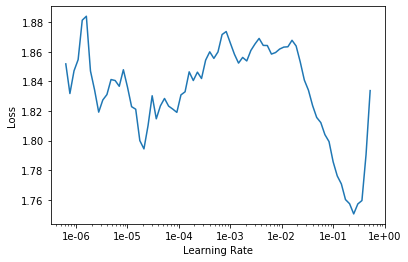

In [35]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [36]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.952238,0.951761,00:09
1,0.857941,0.879722,00:09
2,0.784060,0.834289,00:09
3,0.644651,0.819052,00:08
4,0.552358,0.818256,00:08


In [0]:
learn.save('dotprod')

**Interpretation**

In [0]:
learn.load('dotprod');

In [39]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [42]:
g = rating_movie.groupby(title)['rating'].count()
len(g)

1664

In [43]:
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

**Movie bias**

In [44]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [0]:
item0 = lambda o:o[0]

In [47]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3495),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3181),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2895), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2678), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2597), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2508), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2491), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2387), 'Thinner (1996)', 2.4489795918367347),
 (tensor(-0.2377), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2291), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2281), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2241), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2197), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2175), 'Hellraiser: Bloodline (1996)', 2.0),
 (tensor(-0.2144), 'Bea

In [48]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6376), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5714), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5536), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5504), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5432), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5371), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5256), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5009), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4967), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.4842), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4793), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667),
 (tensor(0.4757), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4744), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4718), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4656), 'To Kill a Mockingbird (1962)', 4.292237442922374)]

**Movie weights**

In [49]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [50]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [52]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0676), 'Close Shave, A (1995)'),
 (tensor(1.0445), 'Chinatown (1974)'),
 (tensor(1.0405), 'When We Were Kings (1996)'),
 (tensor(1.0384), 'Casablanca (1942)'),
 (tensor(1.0205), 'Wrong Trousers, The (1993)'),
 (tensor(0.9906), 'Godfather, The (1972)'),
 (tensor(0.9696), 'Apocalypse Now (1979)'),
 (tensor(0.9559), 'Lawrence of Arabia (1962)'),
 (tensor(0.9526), 'Citizen Kane (1941)'),
 (tensor(0.9457), 'Wallace & Gromit: The Best of Aardman Animation (1996)')]

In [53]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2812), "McHale's Navy (1997)"),
 (tensor(-1.2416), 'Jungle2Jungle (1997)'),
 (tensor(-1.2049), 'Congo (1995)'),
 (tensor(-1.1691), 'Leave It to Beaver (1997)'),
 (tensor(-1.1508), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.1501), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1482), 'Home Alone 3 (1997)'),
 (tensor(-1.1094), 'Bio-Dome (1996)'),
 (tensor(-1.0622), 'Mortal Kombat: Annihilation (1997)'),
 (tensor(-1.0612), 'Grease 2 (1982)')]

In [0]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [55]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8794), 'Keys to Tulsa (1997)'),
 (tensor(0.8722), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.8368), 'Cable Guy, The (1996)'),
 (tensor(0.8215), 'Lost Highway (1997)'),
 (tensor(0.7943), 'Trainspotting (1996)'),
 (tensor(0.7522), 'Very Brady Sequel, A (1996)'),
 (tensor(0.7343), 'Jude (1996)'),
 (tensor(0.7341), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7327), 'Dead Man (1995)'),
 (tensor(0.7161), 'Beavis and Butt-head Do America (1996)')]

In [56]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1452), 'Braveheart (1995)'),
 (tensor(-1.1098), 'Raiders of the Lost Ark (1981)'),
 (tensor(-1.0292), 'Titanic (1997)'),
 (tensor(-0.8663), 'Pretty Woman (1990)'),
 (tensor(-0.8641), 'Forrest Gump (1994)'),
 (tensor(-0.8539), "It's a Wonderful Life (1946)"),
 (tensor(-0.8537), 'Independence Day (ID4) (1996)'),
 (tensor(-0.8507), "Mr. Holland's Opus (1995)"),
 (tensor(-0.8435), 'American President, The (1995)'),
 (tensor(-0.8397), 'Top Gun (1986)')]

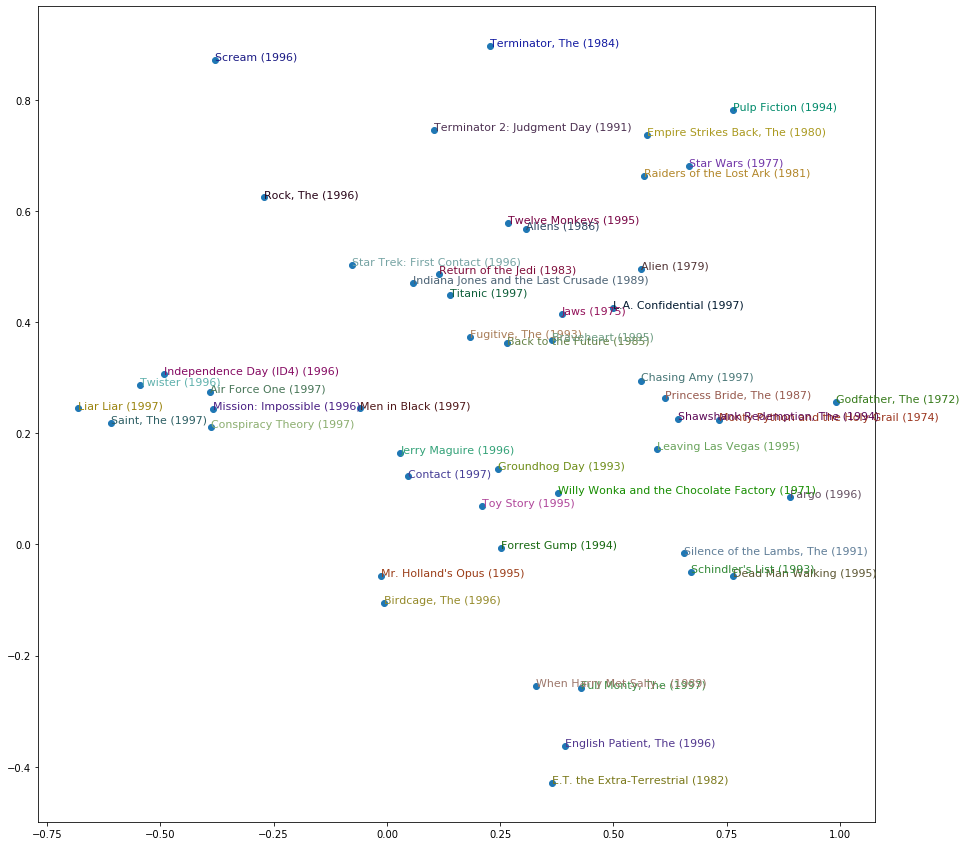

In [57]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()